Import packages

In [3]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm

load abf file

In [21]:
abf = pyabf.ABF('/Users/Haley/Desktop/Neuroscience Lab/sandeeps data/cell1/2012_08_01_0009.abf')

The abf files contain sweeps in forms of numpy arrays

In [22]:
abf.setSweep(sweepNumber=0, channel=0)
print("data:",abf.sweepY)
print("time:",abf.sweepX)
print("length of arrays:",len(abf.sweepX))
print("channel count:",abf.channelCount)

data: [145.2637 146.4844 146.9726 ... 144.5312 145.7519 146.2402]
time: [ 0.  0.  0. ... 10. 10. 10.]
length of arrays: 1000000
channel count: 4


Function to find standard deviation to automatically scale y-axis

In [23]:
def get_std_range(array, stdnum=8):
    """
    Returns the lower and upper bounds of a region centered at the mean
    that contains the given percentage of the data, assuming a normal distribution.

    Returns:
    - (lower_bound, upper_bound)
    """
    mean = np.mean(array)
    std = np.std(array)

    lower = mean - stdnum * std
    upper = mean + stdnum * std
    return lower, upper

Funtion that plots motor neuron activity given an abf file

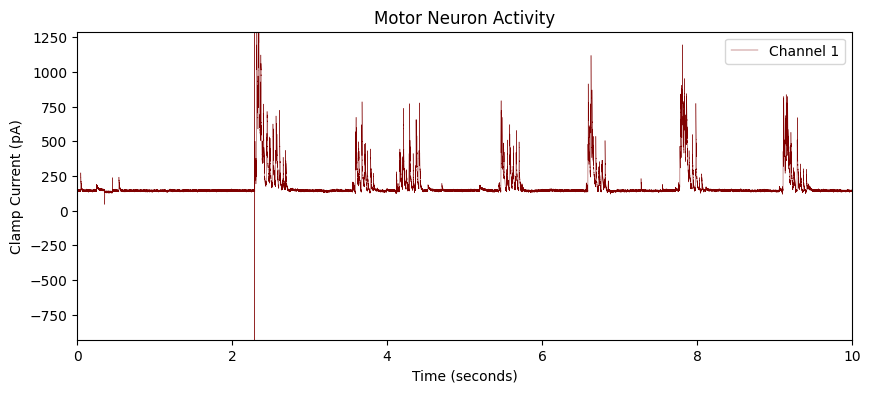

In [35]:
def plot_motorneuron_activity(abf):
    fig = plt.figure(figsize=(10, 4))
    # plot the first channel
    abf.setSweep(sweepNumber=0, channel=0)
    plt.plot(abf.sweepX, abf.sweepY, label="Channel 1",linewidth = 0.3,color='maroon')
    y_min, y_max = get_std_range(abf.sweepY,10)

    # decorate the plot
    plt.title("Motor Neuron Activity")
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([0, 10, y_min, y_max]) # x bound, y bound
    plt.legend()
    plt.show()

plot_motorneuron_activity(abf)

Function that plots ventral root bursts given abf file

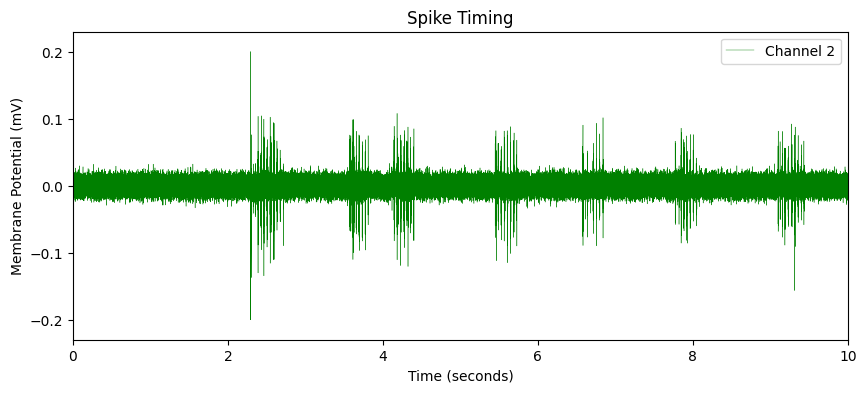

In [25]:
def plot_ventralroot_bursts2(abf):   
    fig = plt.figure(figsize=(10, 4))

    # plot the second channel
    abf.setSweep(sweepNumber=0, channel=1)
    plt.plot(abf.sweepX, abf.sweepY, label="Channel 2",linewidth = 0.3,color='green')
    y_min, y_max = get_std_range(abf.sweepY,22)

    # decorate the plot
    plt.title("Spike Timing")
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([0, 10, y_min, y_max]) # x bound, y bound
    plt.legend()
    plt.show()
plot_ventralroot_bursts2(abf)

ANNOTATIONS FILE: load csv as a pandas data frame

In [26]:
annotations = pd.read_csv('/Users/Haley/Desktop/Neuroscience Lab/sandeeps data/cell1/2012_08_01_0009.csv')



Make new column in data frame in units of seconds

In [27]:
annotations["Seconds"] = annotations['On time']*0.001
annotations.loc[0:1,"Seconds"]

t_0 = annotations.loc[0,"Seconds"] 
t_f = annotations.loc[1,"Seconds"]
annotations
print(np.searchsorted(abf.sweepX, t_0))
print(np.searchsorted(abf.sweepX, t_f))

230481
233290


Add seconds column to data frame

In [28]:
def add_seconds(df):
    '''
    Function that takes in df with milisecond time stamps and adds a column with seconds time stamps
    '''
    df["Seconds"] = df['On time']*0.001
    return df

Function that plots a channel of abf file given time bounds and channel

/var/folders/mw/pz4gm95j6zb7syl48vm11wrw0000gn/T/ipykernel_26996/114400010.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


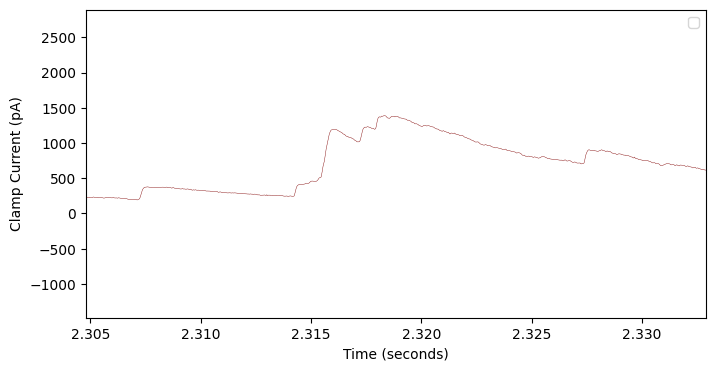

In [29]:
def plot_one_waveform(abf,t_0,t_f,ch=0,title=None):
    '''
    Function plots motor activity of abf file given time bound and channel
    '''    
    fig = plt.figure(figsize=(8, 4))
    abf.setSweep(sweepNumber=0, channel=ch)
    plt.plot(abf.sweepX, abf.sweepY,linewidth = 0.3,color='maroon')
    y_idx_start = np.searchsorted(abf.sweepX, t_0)
    y_idx_end = np.searchsorted(abf.sweepX, t_f)
    y_min, y_max = get_std_range(abf.sweepY[y_idx_start:y_idx_end],6)

    plt.title(title)
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.axis([t_0,t_f,y_min, y_max]) # x bound, y bound
    plt.legend()
    plt.show()
plot_one_waveform(abf,t_0,t_f)   

Final plot_one_waveform function with labels

In [30]:
def plot_one_waveform(abf, t_0, t_f, ch=0, title=None, freq=None):
    '''
    Function plots motor activity of abf file given time bound and channel,
    and adds a secondary x-axis representing phase from 0 to 1.
    '''    
    fig, ax = plt.subplots(figsize=(8, 4))
    abf.setSweep(sweepNumber=0, channel=ch)
    ax.plot(abf.sweepX, abf.sweepY, linewidth=0.3, color='maroon', label='Motoneuron Activity')

    # Index range for y-axis scaling
    y_idx_start = np.searchsorted(abf.sweepX, t_0)
    y_idx_end = np.searchsorted(abf.sweepX, t_f)
    y_min, y_max = get_std_range(abf.sweepY[y_idx_start:y_idx_end], 6)

    # Main plot
    
    # Add frequency to title
    full_title = title if title else "One waveform"
    if freq is not None:
        full_title += f"\nFrequency: {freq:.2f} Hz"
    ax.set_title(full_title)

    # ax.set_title(title)
    ax.set_ylabel(abf.sweepLabelY)
    ax.set_xlabel(abf.sweepLabelX)
    ax.set_xlim([t_0, t_f])
    ax.set_ylim([y_min, y_max])
    ax.legend()

    # Add a secondary x-axis for phase (0 to 1)
    def time_to_phase(x): return (x - t_0) / (t_f - t_0)
    def phase_to_time(x): return x * (t_f - t_0) + t_0

    secax = ax.secondary_xaxis('top', functions=(time_to_phase, phase_to_time))
    secax.set_xlabel('Phase (0 to 1)')
    secax.set_xlim([0, 1])

    plt.tight_layout()
    plt.show()


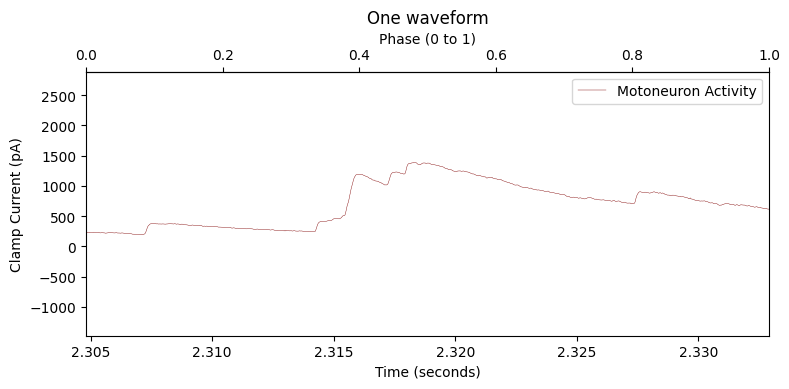

In [31]:
plot_one_waveform(abf,t_0,t_f)   

Load annotations file again:

In [33]:
df = pd.read_csv('/Users/Haley/Desktop/Neuroscience Lab/sandeeps data/cell1/2012_08_01_0009.csv')

Final plot waveforms function:

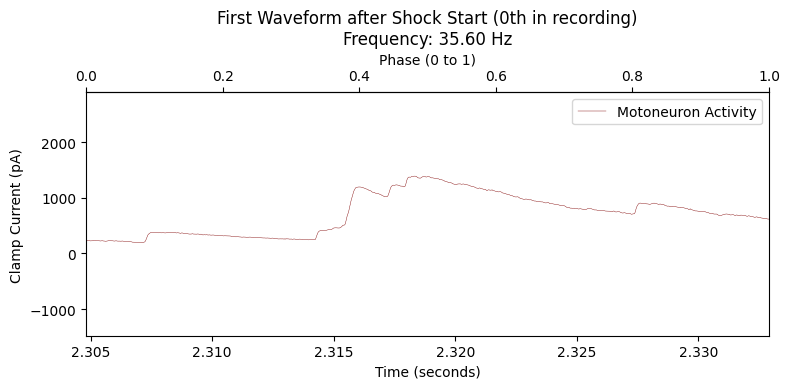

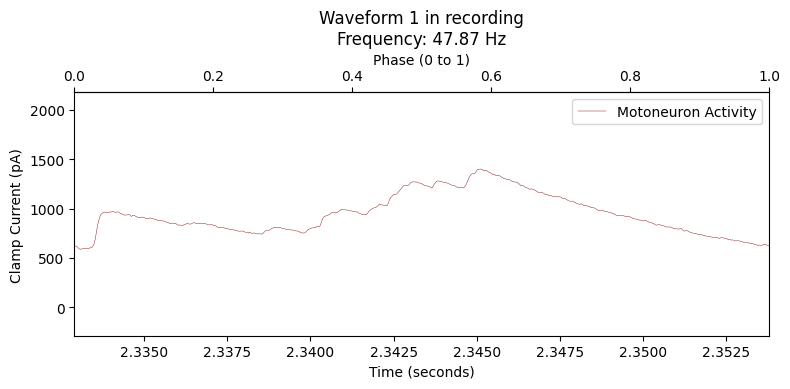

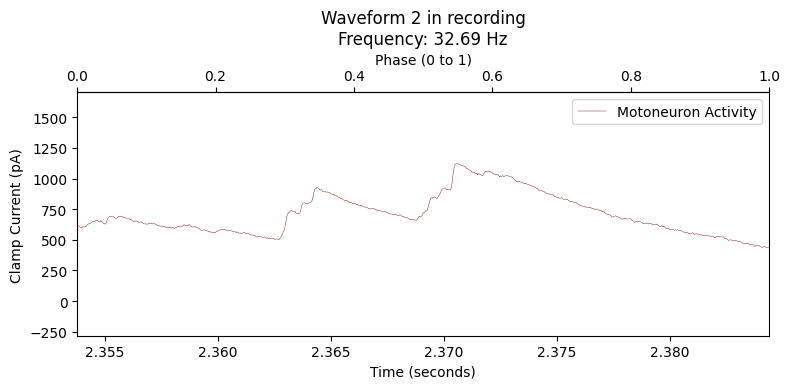

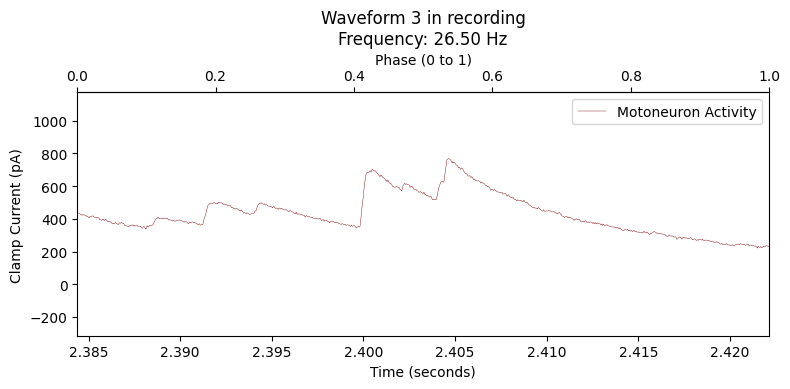

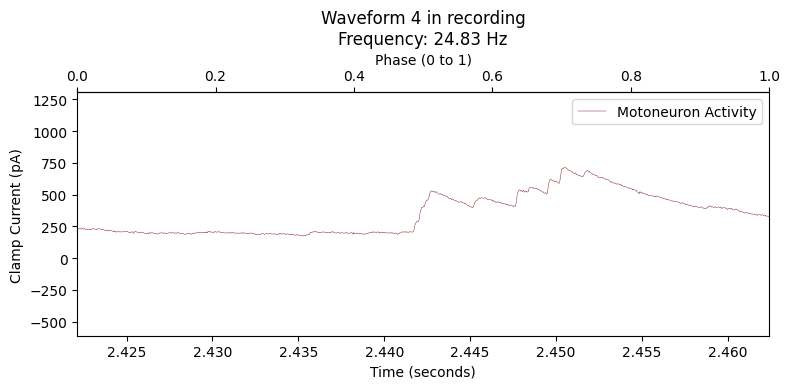

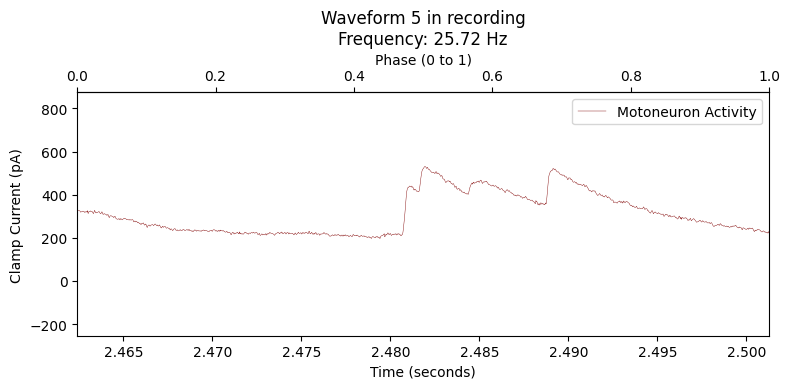

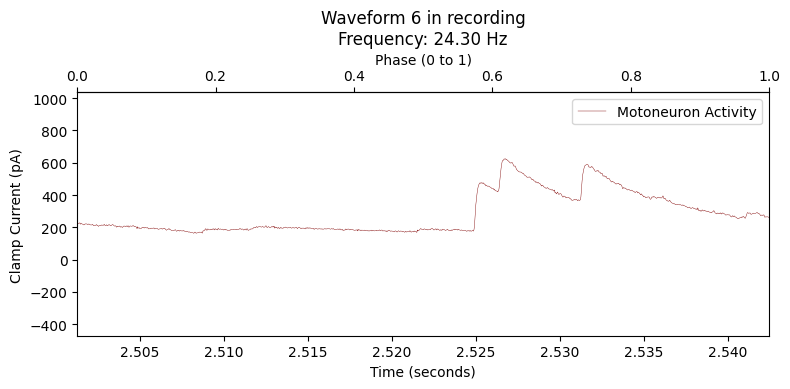

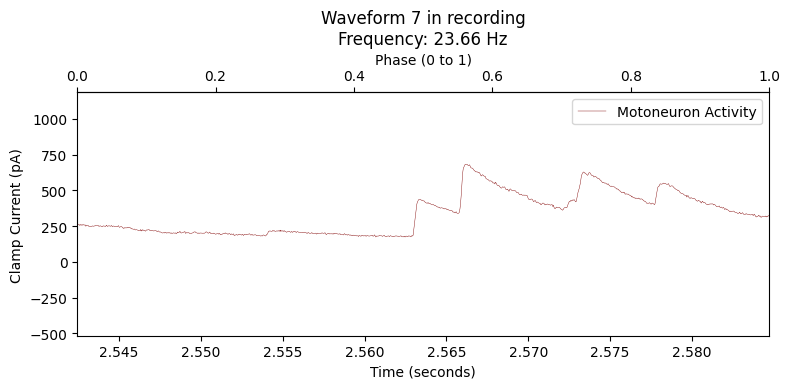

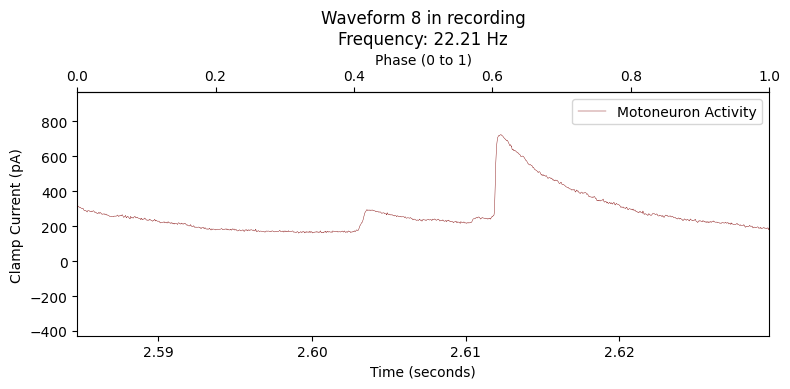

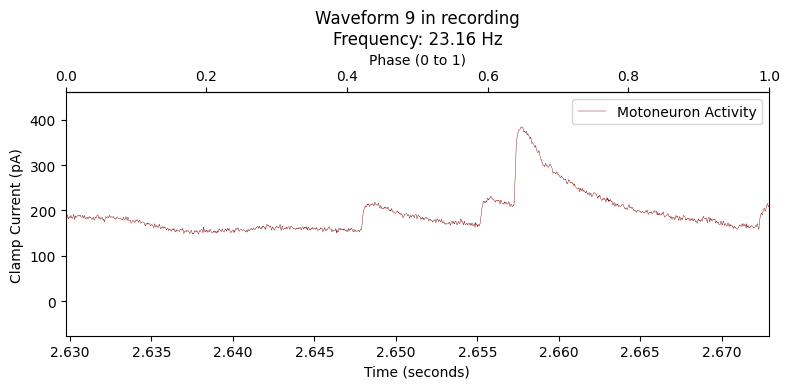

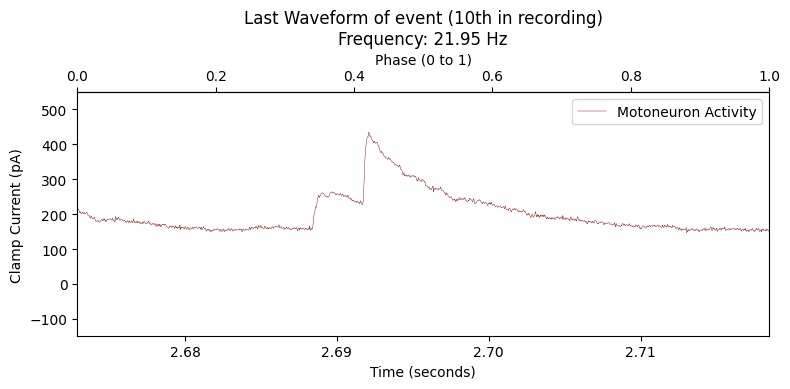

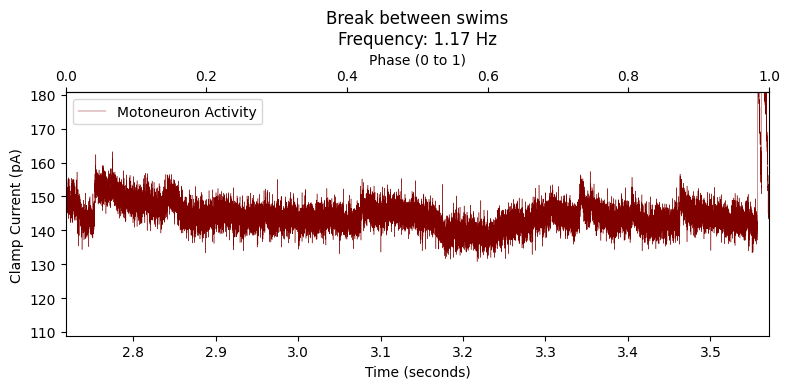

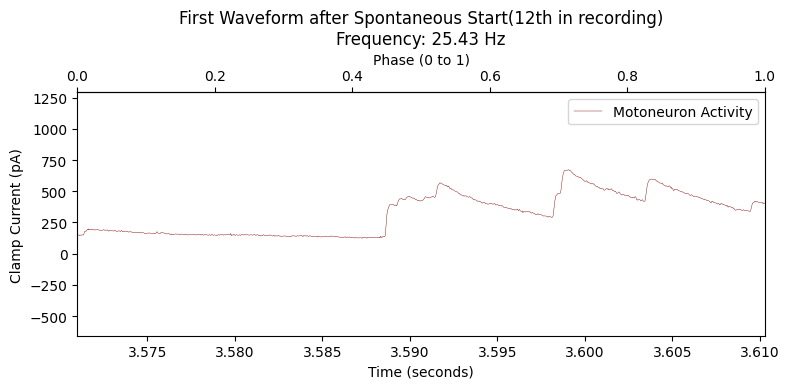

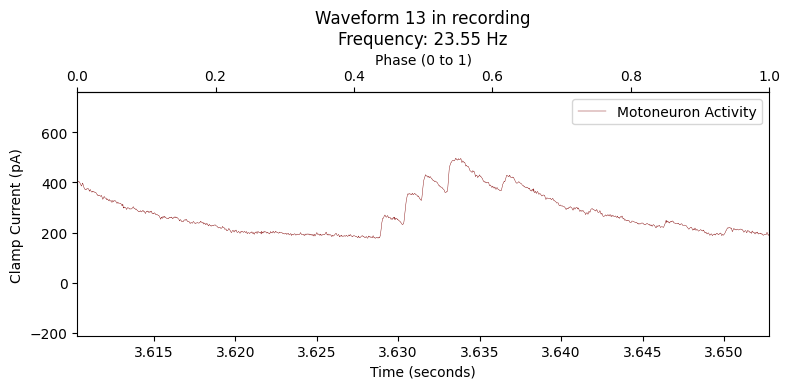

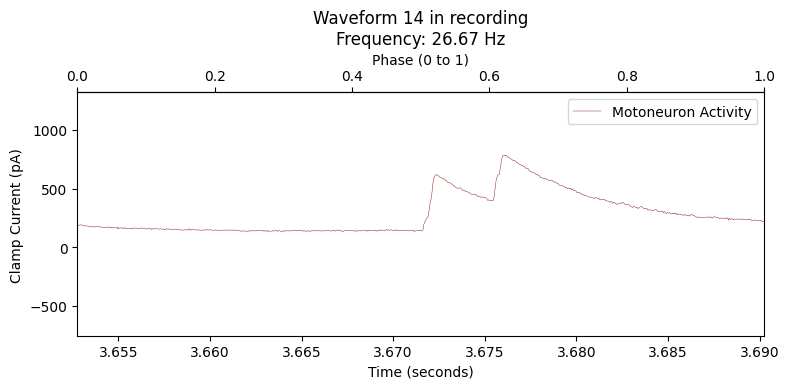

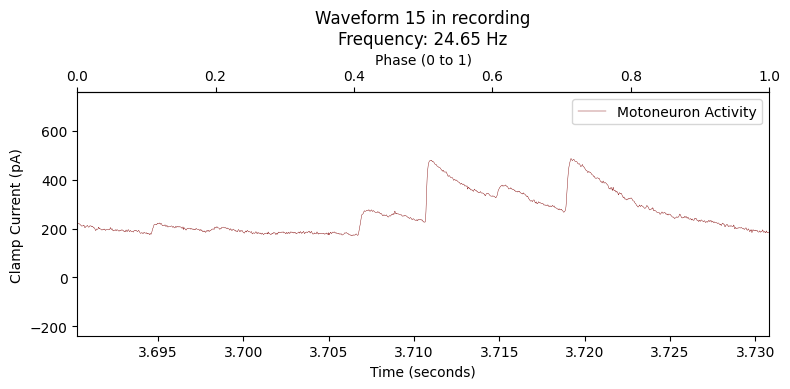

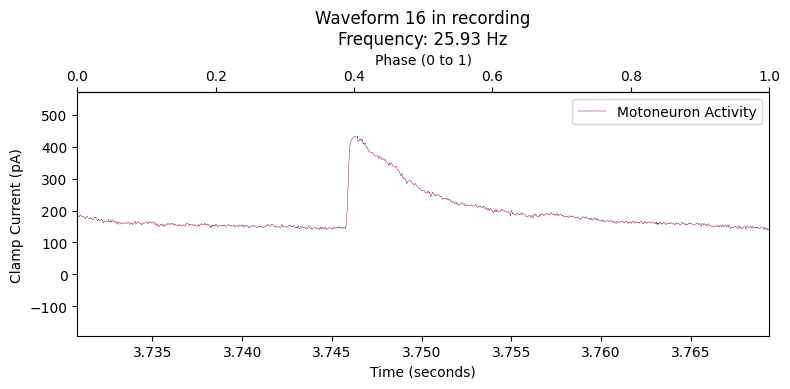

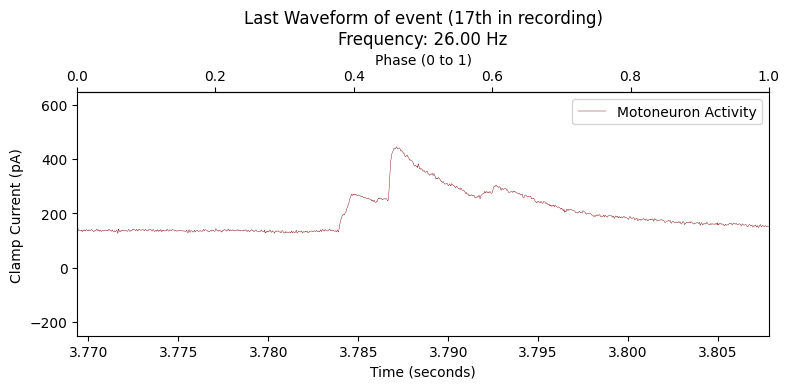

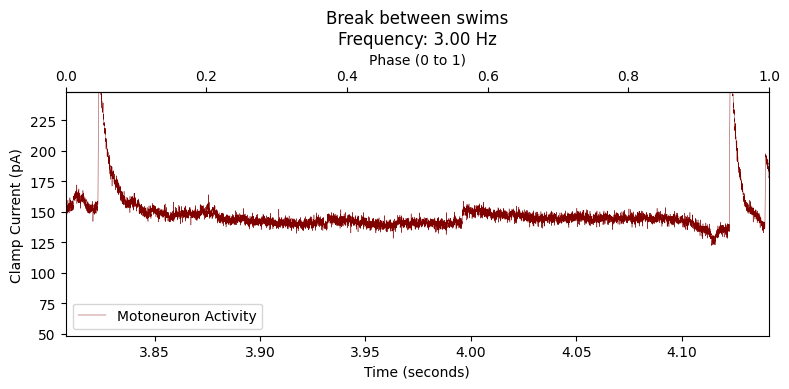

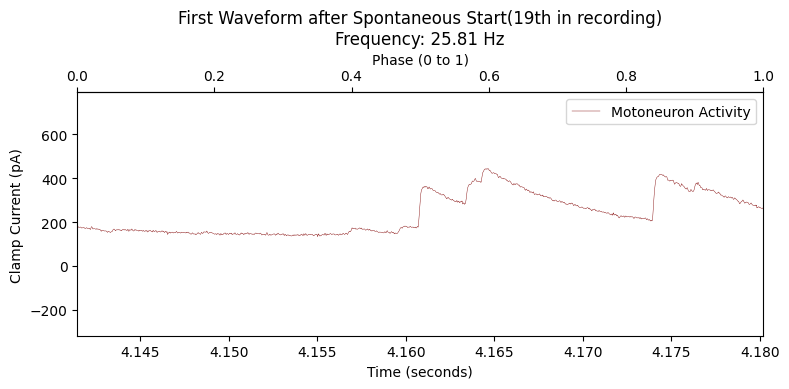

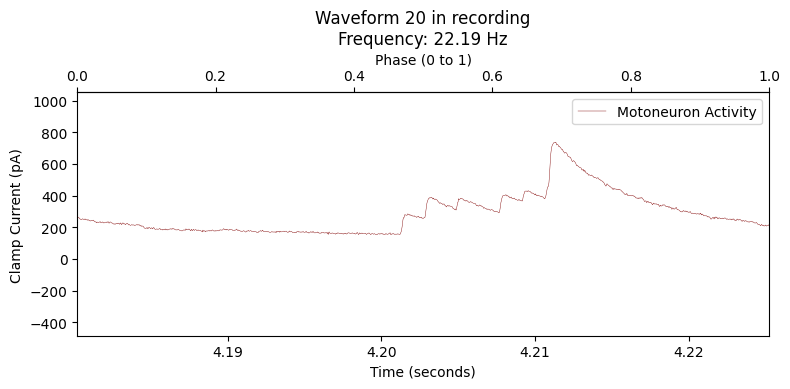

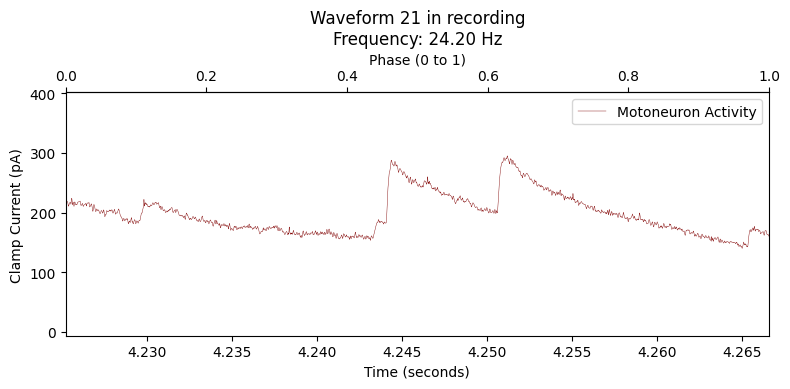

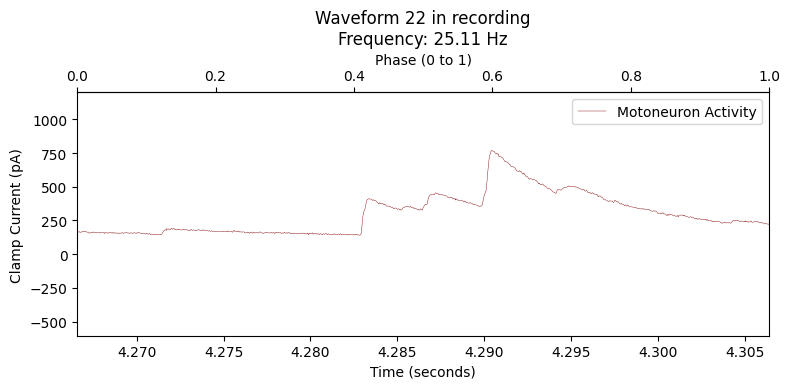

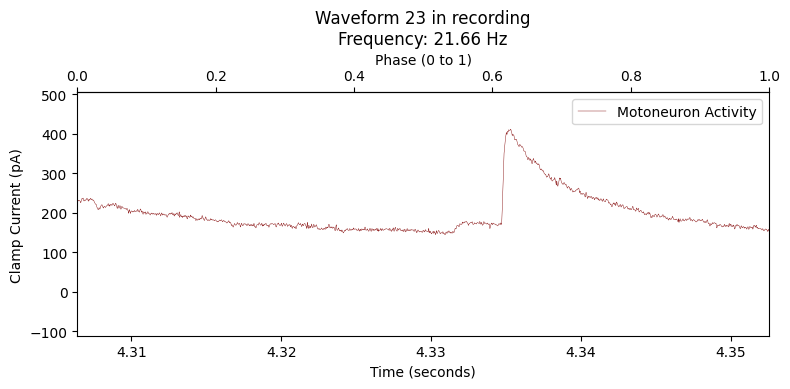

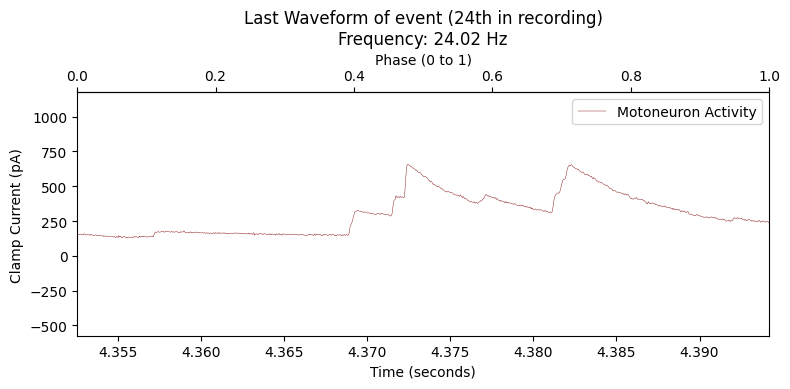

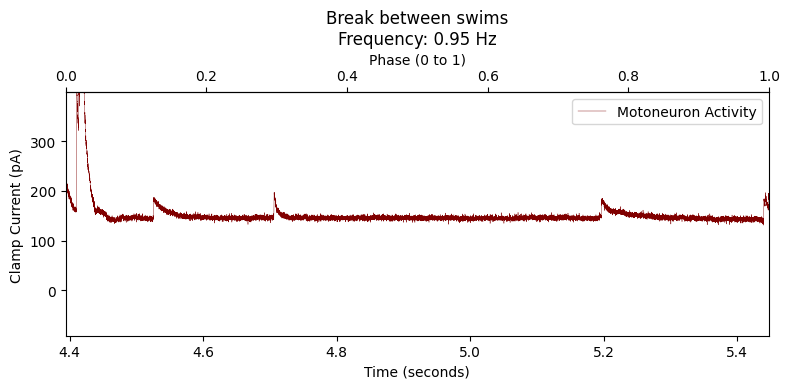

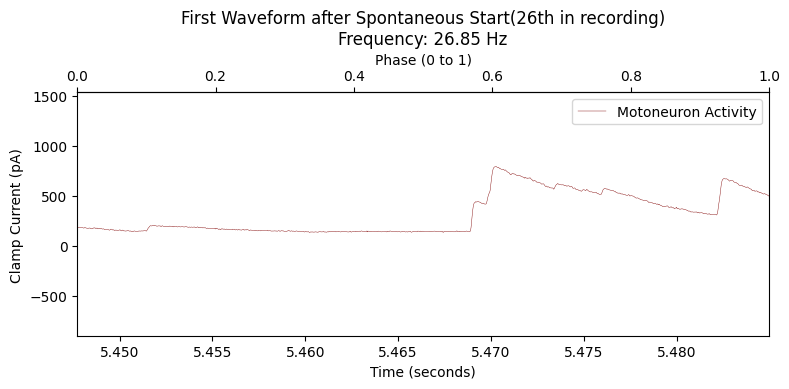

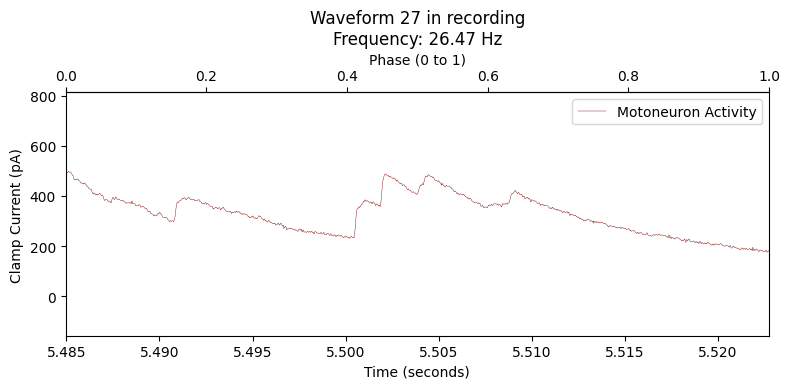

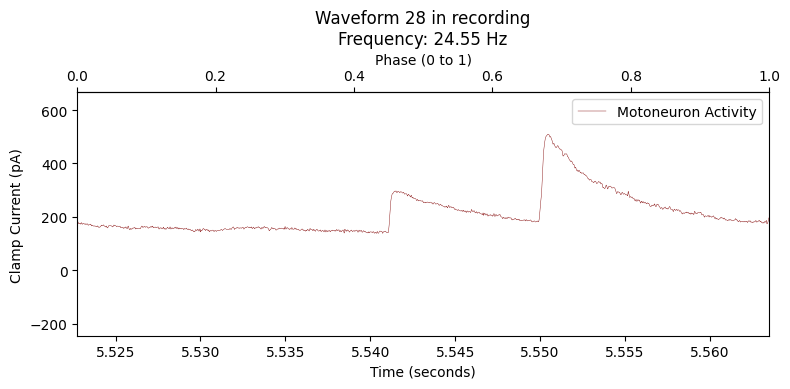

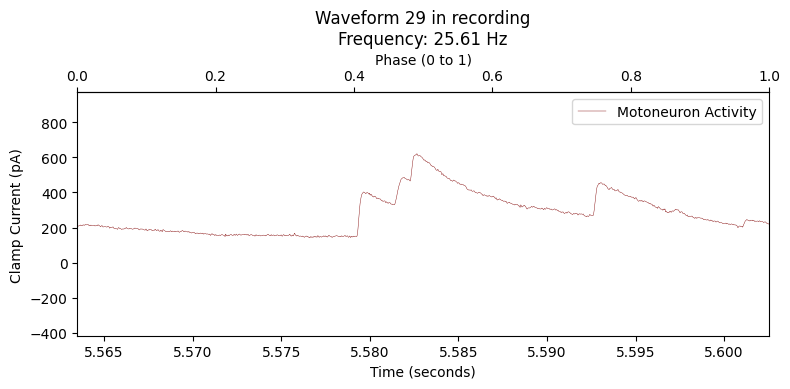

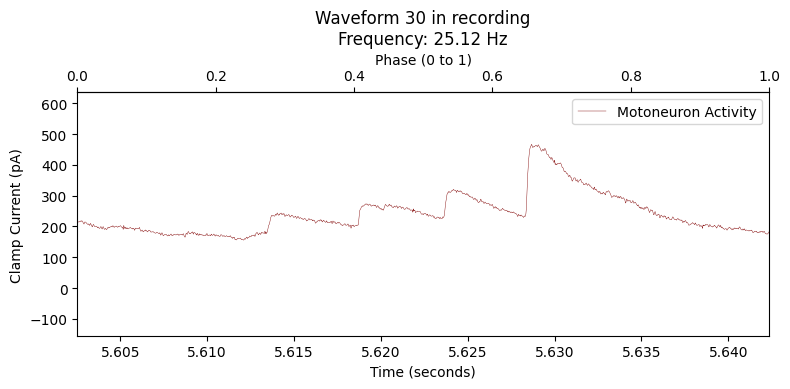

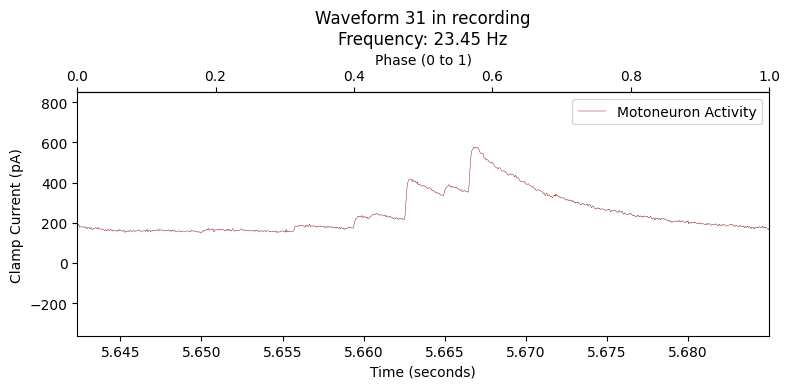

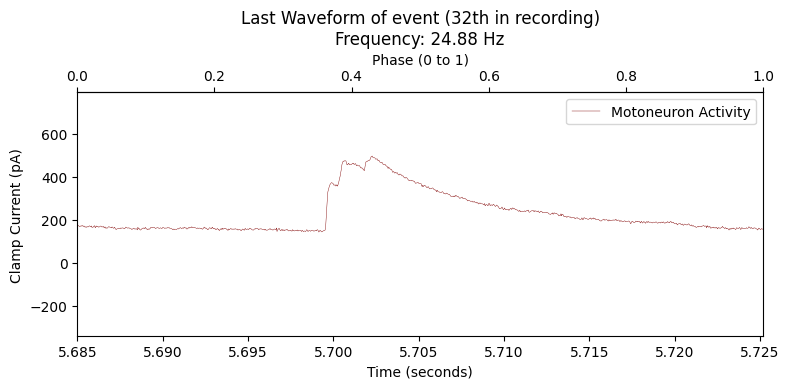

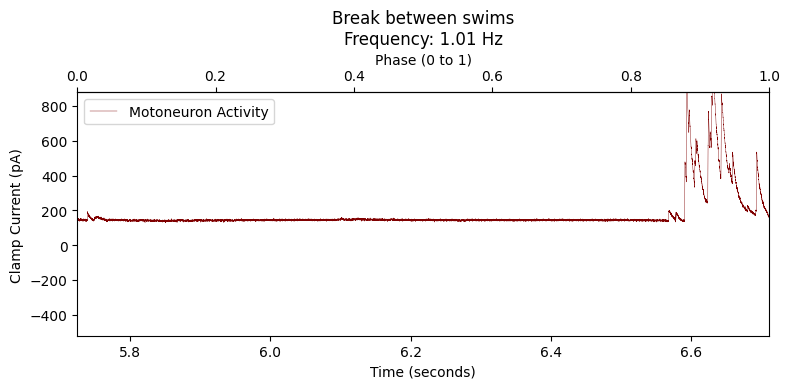

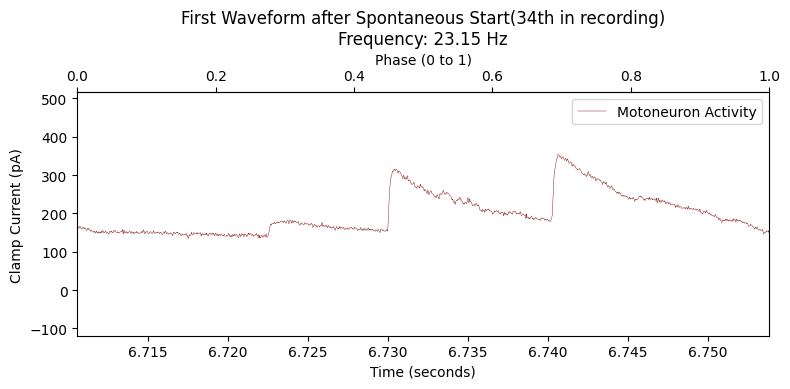

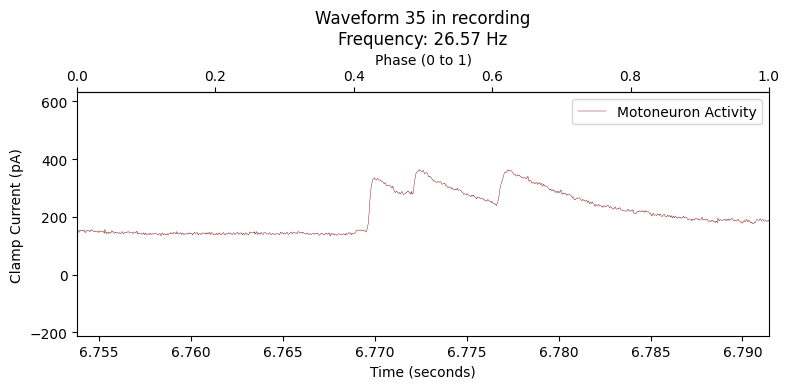

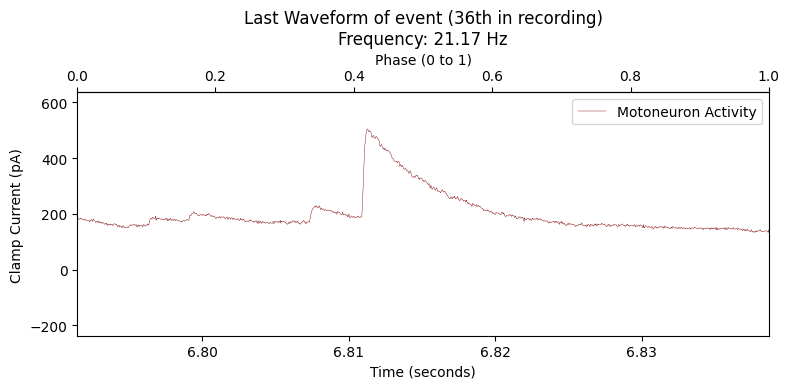

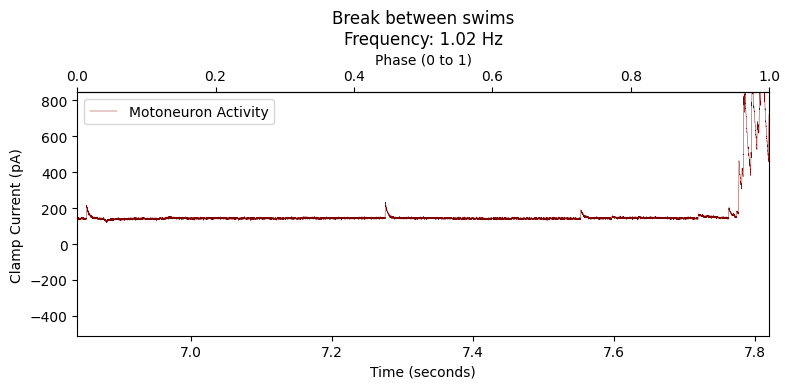

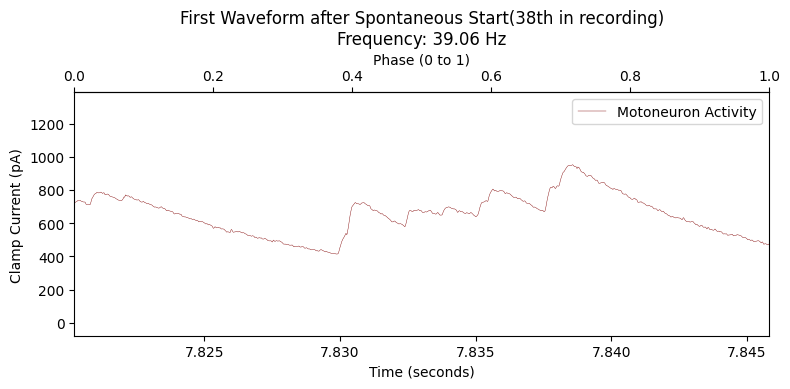

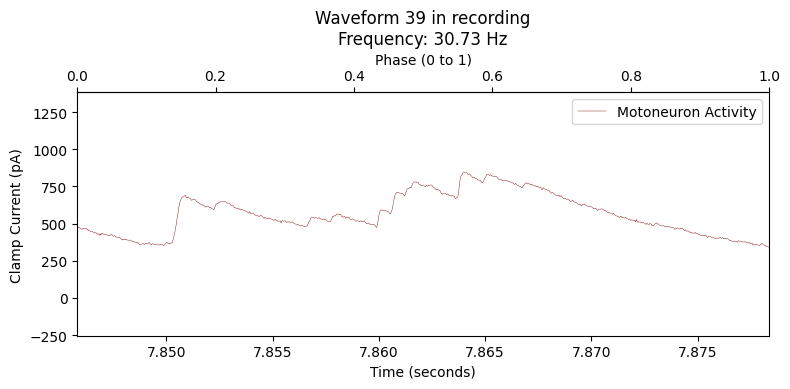

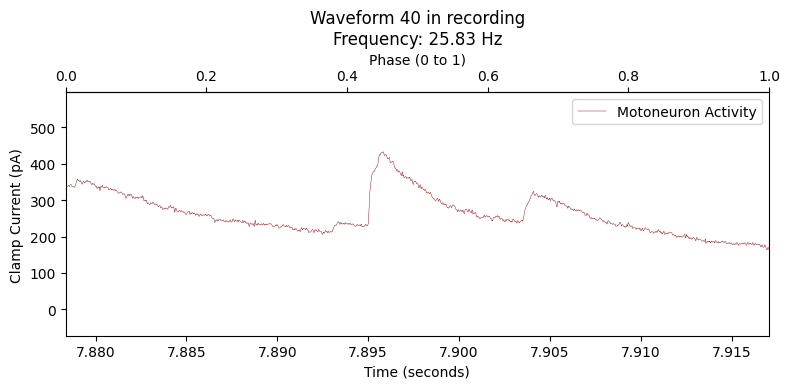

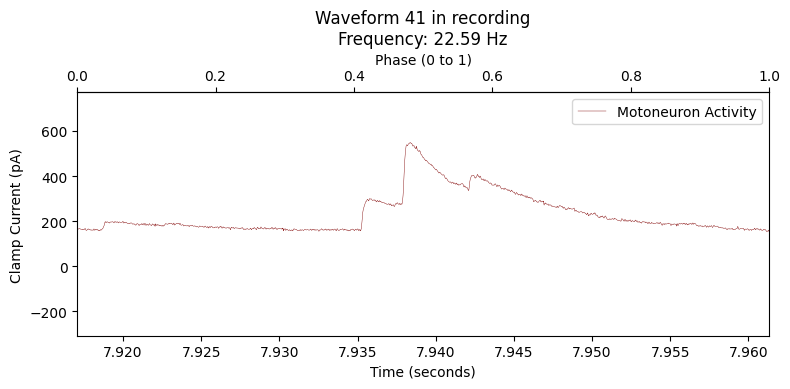

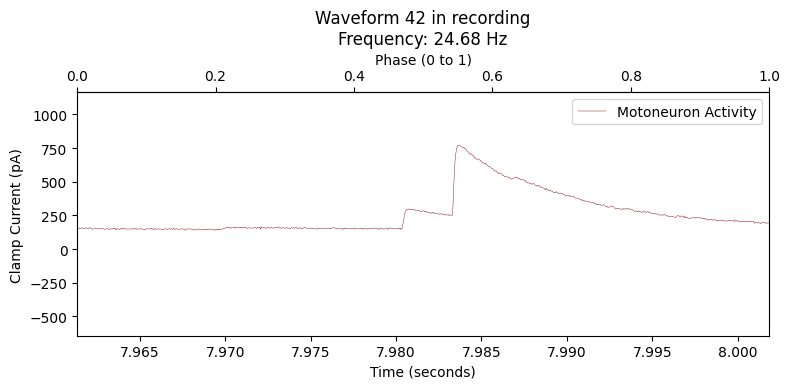

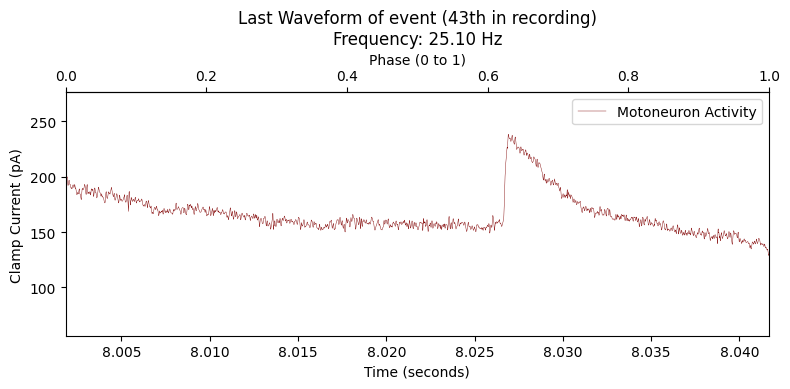

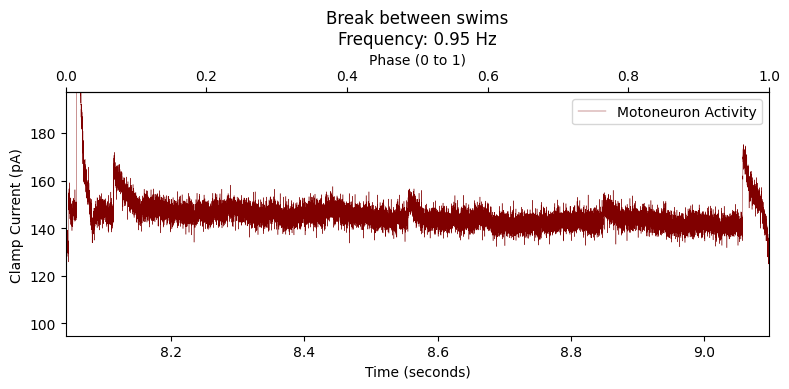

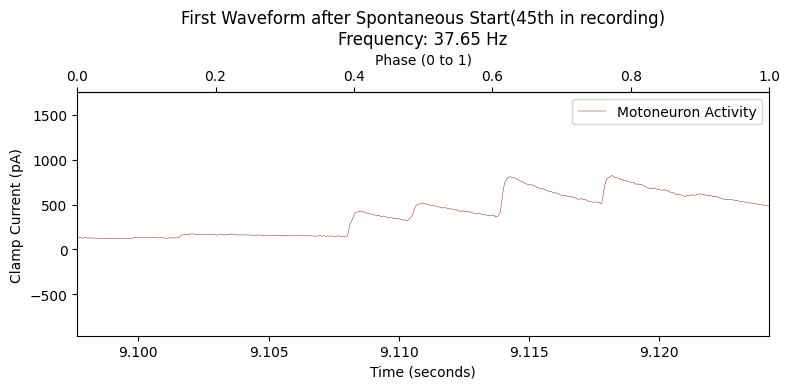

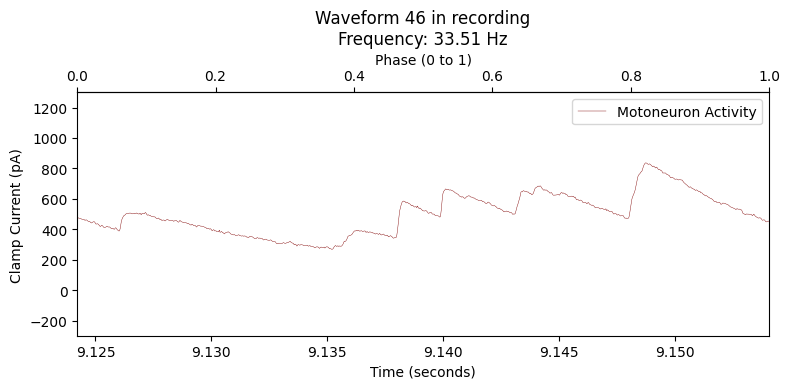

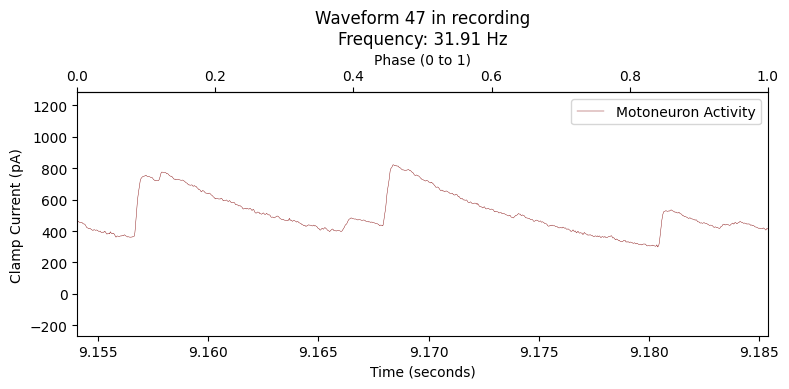

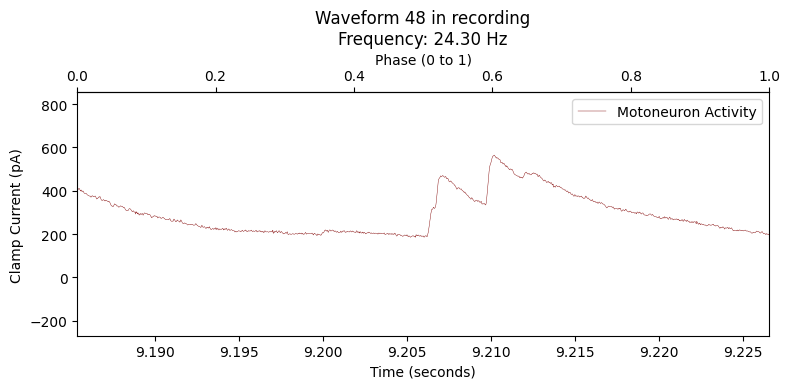

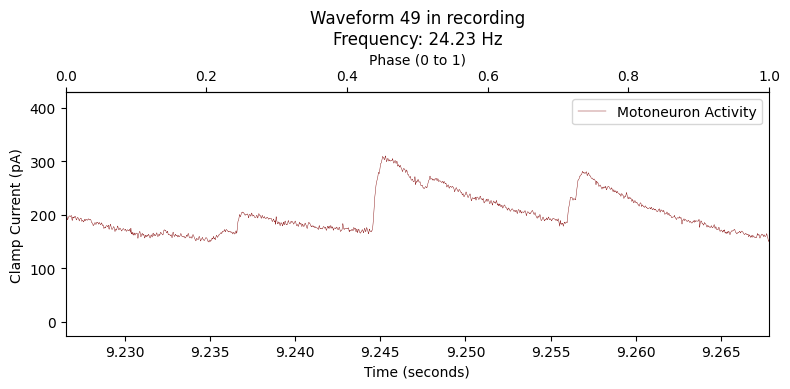

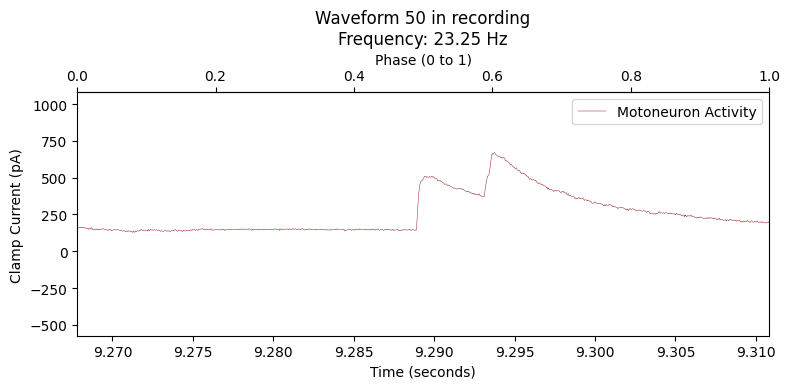

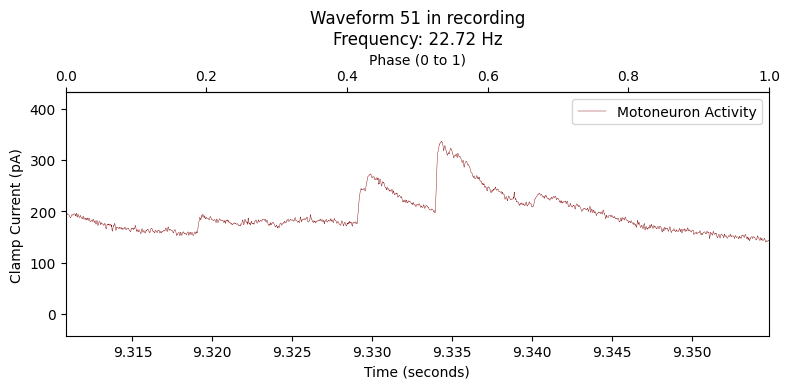

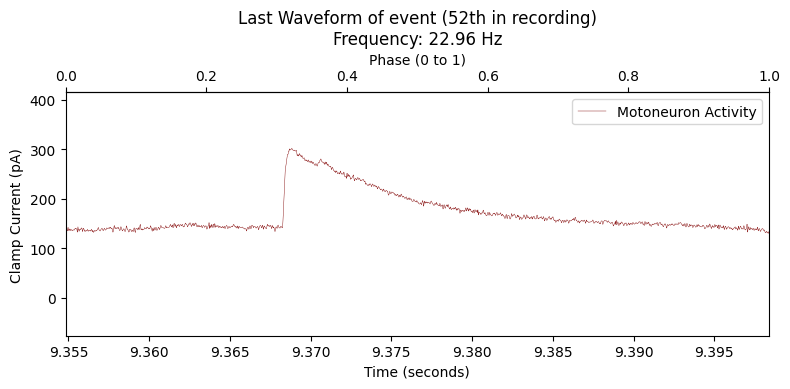

In [34]:
def plot_waveforms(df, abf, ch=0):
    df = add_seconds(df)
    for i in range(len(df) - 1):
        t_0 = df.loc[i, 'Seconds']
        t_f = df.loc[i + 1, 'Seconds']
        freq = df.loc[i + 1, "Freq"]
        tags_current = df.loc[i, "Tags"] if isinstance(df.loc[i, "Tags"], str) else ""
        tags_next = df.loc[i + 1, "Tags"] if isinstance(df.loc[i + 1, "Tags"], str) else ""

        # Determine label based on tags
        if "start" in tags_current:
            if "spontaneous" in tags_current:
                label = f'First Waveform after Spontaneous Start({i}th in recording)'
            elif "shock" in tags_current:
                label = f'First Waveform after Shock Start ({i}th in recording)'
        elif "end" in tags_next:
            label = f'Last Waveform of event ({i}th in recording)'
        elif "end" in tags_current:
            label = 'Break between swims'
        else:
            label = f'Waveform {i} in recording'

        # Call the plot_one_waveform function with the determined label
        plot_one_waveform(abf, t_0, t_f, ch=ch, title=label,freq=freq)

# Call the function
plot_waveforms(df, abf, ch=0)
